
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [6]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [7]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [8]:
X = ha[['age', 'chol']]
y = ha['cp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
param = {'n_neighbors': [1, 5, 9, 13, 17, 21, 25]}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param, cv=5, scoring='accuracy')
grid_searchfit = grid_search.fit(X_train, y_train)



print(grid_searchfit.best_estimator_)
print(grid_searchfit.score(X_test, y_test))

KNeighborsClassifier(n_neighbors=17)
0.4927536231884058


In [10]:
from sklearn.tree import DecisionTreeClassifier


param2 = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtree_class = DecisionTreeClassifier(random_state=42)

grid_search2 = GridSearchCV(dtree_class, param2, cv=5, n_jobs=-1, verbose=1)
grid_search2fit = grid_search2.fit(X_train, y_train)

print(grid_search2fit.best_params_)
print(grid_search2fit.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.463768115942029


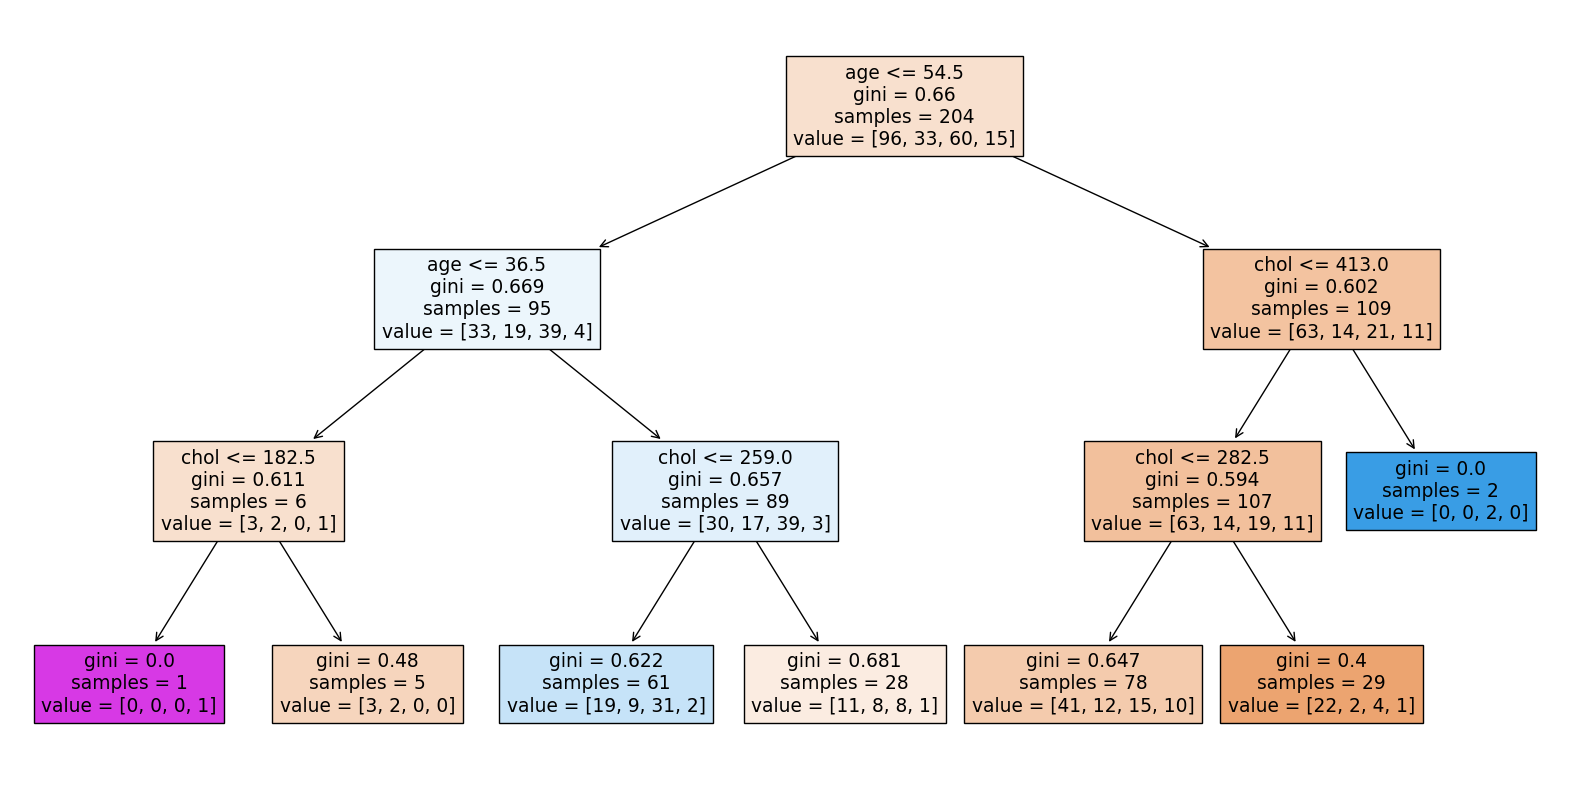

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

feature_names = X_train.columns.tolist()

plt.figure(figsize=(20,10))
plot_tree(grid_search2fit.best_estimator_, filled=True, feature_names=feature_names, class_names=None)
plt.show()

The first split is age at 54.5 years old. <br>

The left split is age at 36.5 years old. The right split is cholesterol at 413 mg/dl.

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [20]:
lda.score(X_test, y_test)

0.4782608695652174

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [21]:
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_0,cp_is_1,cp_is_2,cp_is_3
0,63,1,3,145,233,0,150,1,0,0,0,1
1,37,1,2,130,250,1,187,1,0,0,1,0
2,56,1,1,120,236,1,178,1,0,1,0,0
3,57,0,0,120,354,1,163,1,1,0,0,0
4,57,1,0,140,192,1,148,1,1,0,0,0


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Initializing a dictionary to store F1 scores for each cp category
f1_scores = {}

for category in [0, 1, 2, 3]:
    # Create a new binary target column for the current cp category
    ha[f'cp_is_{category}'] = (ha['cp'] == category).astype(int)

    # Prepare the Data (using only 'age' and 'chol' as predictors)
    X = ha[['age', 'chol']]  # Select only 'age' and 'chol' columns
    y = ha[f'cp_is_{category}']

    # Split the Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the Model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make Predictions and Evaluate
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[category] = f1

# Find the cp category with the highest F1 score
best_cp_category = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_cp_category]

print("F1 Scores for each cp category:", f1_scores)
print(f"Best performing cp category: {best_cp_category} with an F1 Score of {best_f1_score}")

F1 Scores for each cp category: {0: 0.5555555555555556, 1: 0.0, 2: 0.0, 3: 0.0}
Best performing cp category: 0 with an F1 Score of 0.5555555555555556


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [33]:
from sklearn.metrics import roc_auc_score


def func(pair):
    new_ha = ha[ha['cp'].isin(pair)]

    # Prepare the Data
    X = new_ha[['age', 'chol']]
    y = new_ha['cp']

    # Split the Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the Model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make Predictions and Evaluate
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the second class in the pair
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    
    return roc_auc

#print("ROC-AUC Scores for each cp pair:", roc_auc_scores)
#print(f"Best performing cp pair: {best_cp_pair} with a ROC-AUC Score of {best_roc_auc_score}")

In [35]:
first = [0,1]
func(first)

0.5972222222222222

In [36]:
second = [0,2]
func(second)

0.6884700665188471

In [37]:
third = [0,3]
func(third)

0.5202020202020201

Best pair was 0,2 with the highest roc auc score